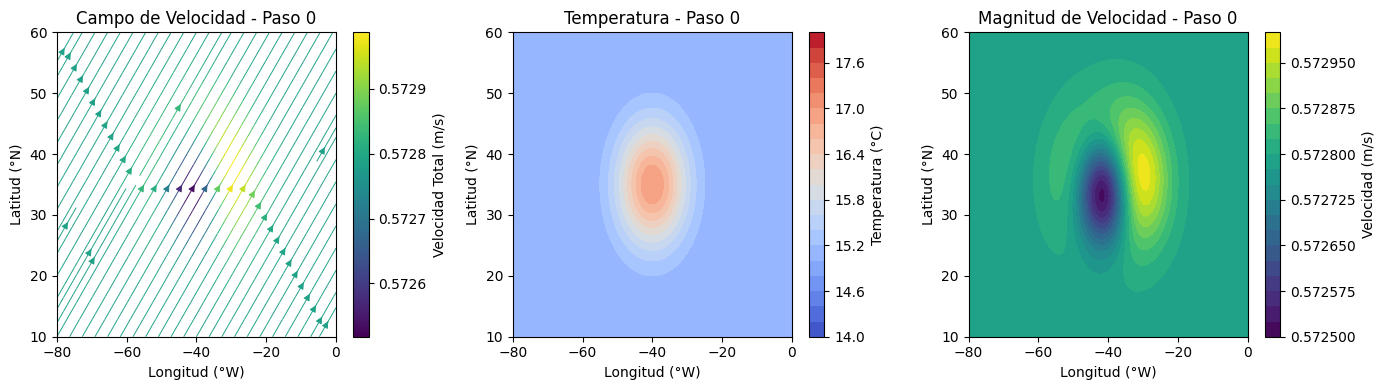

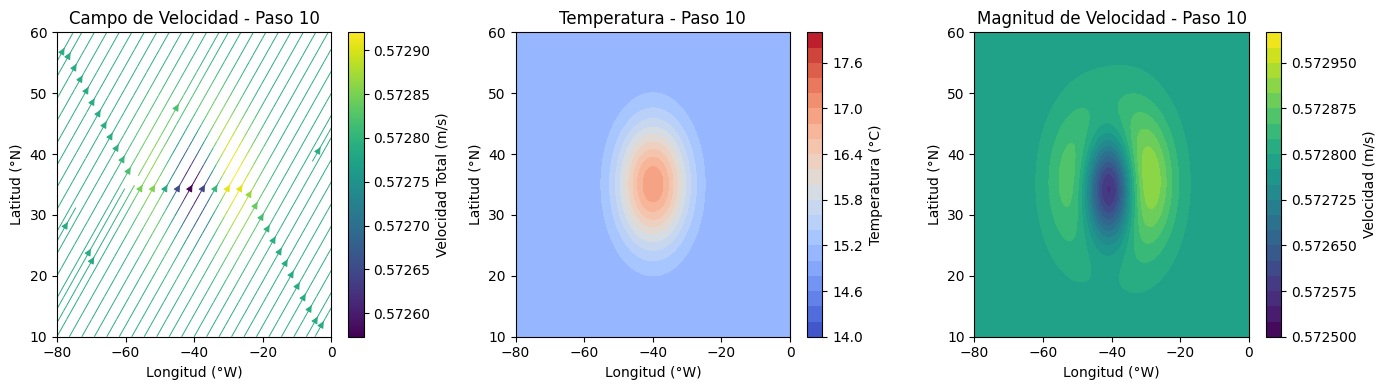

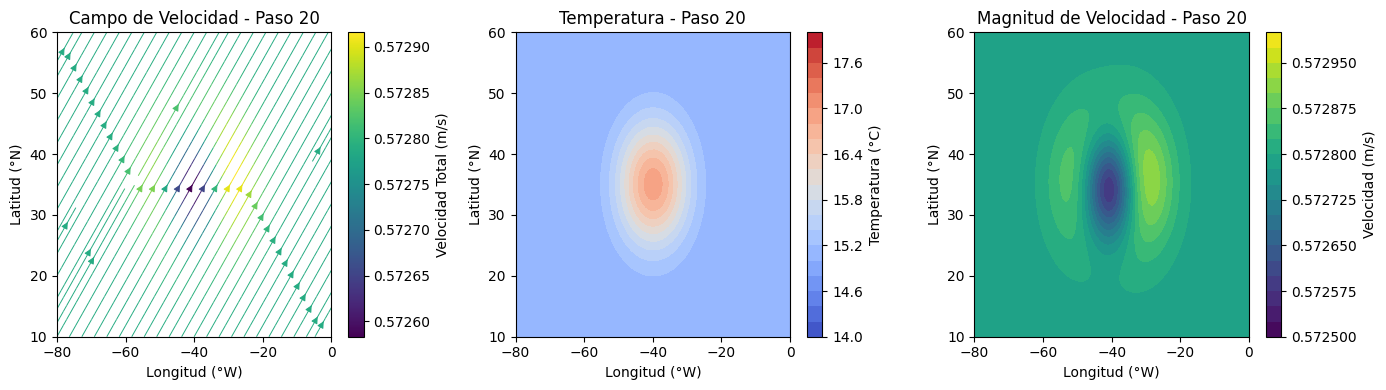

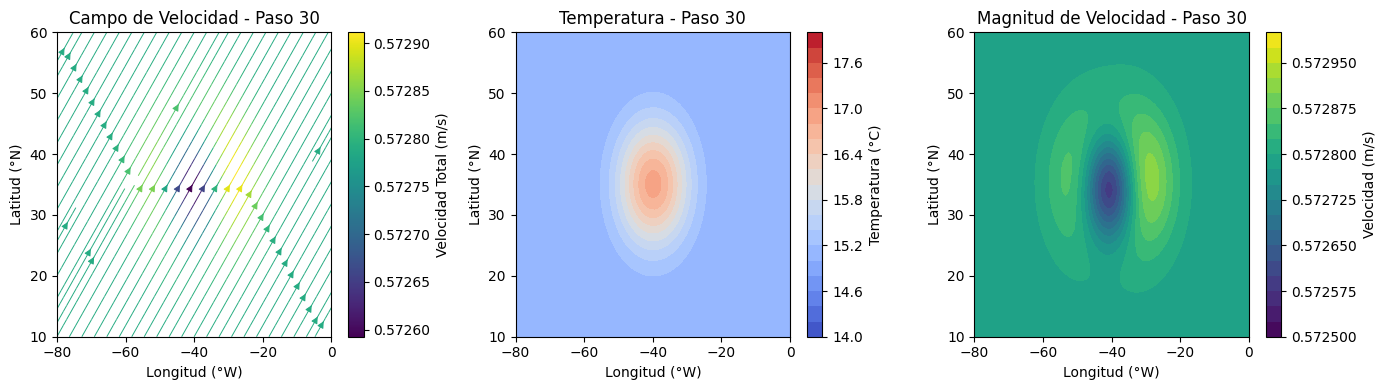

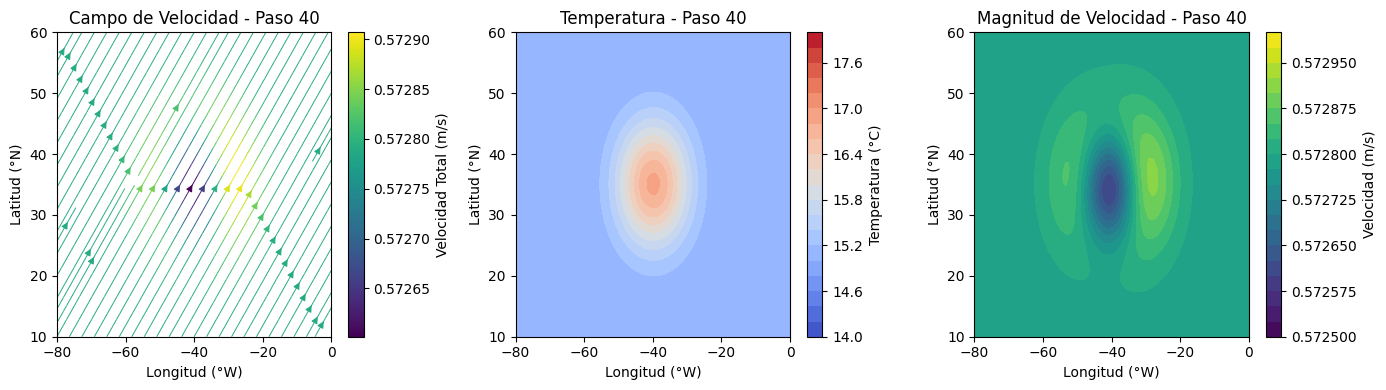

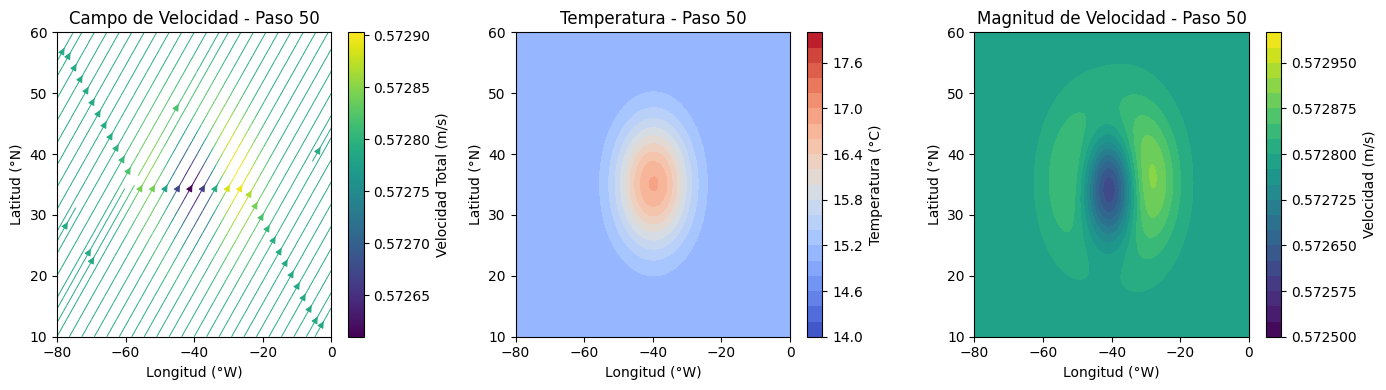

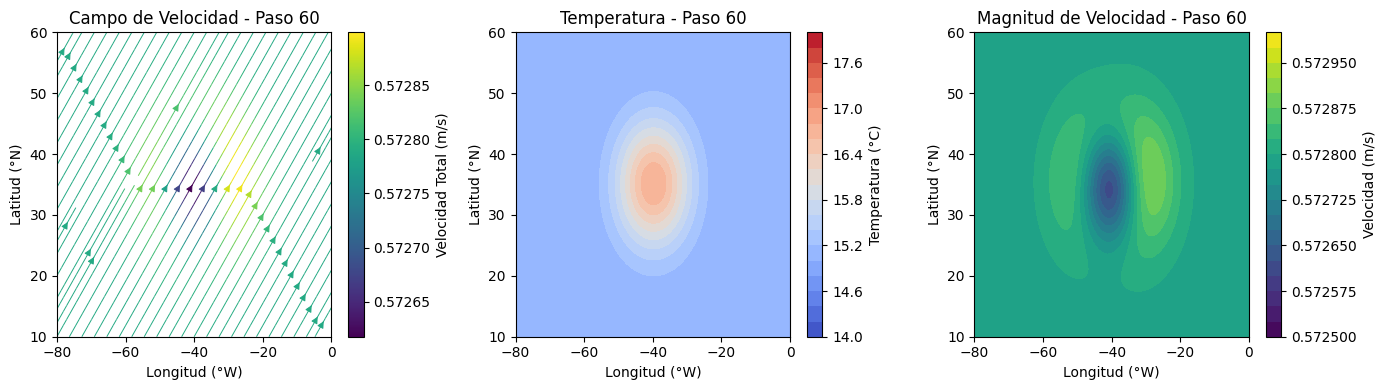

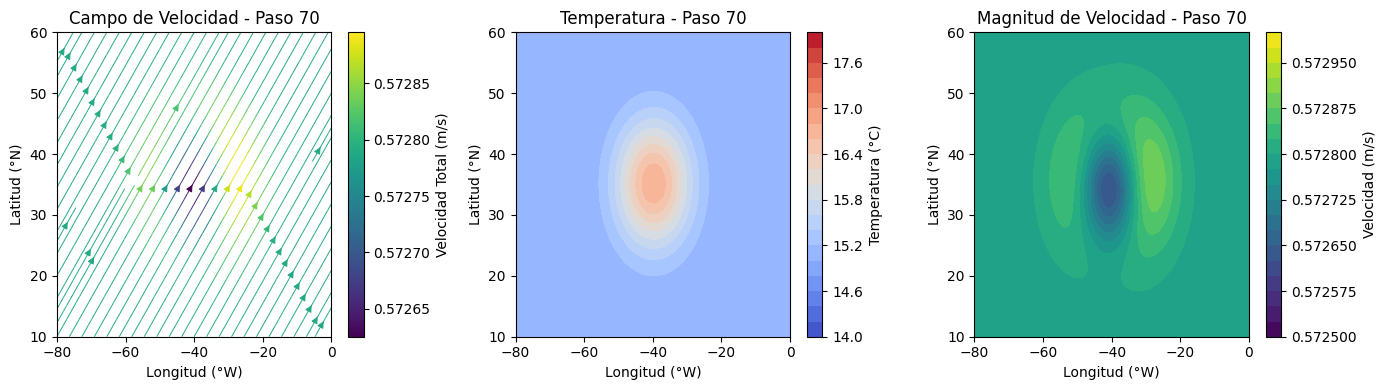

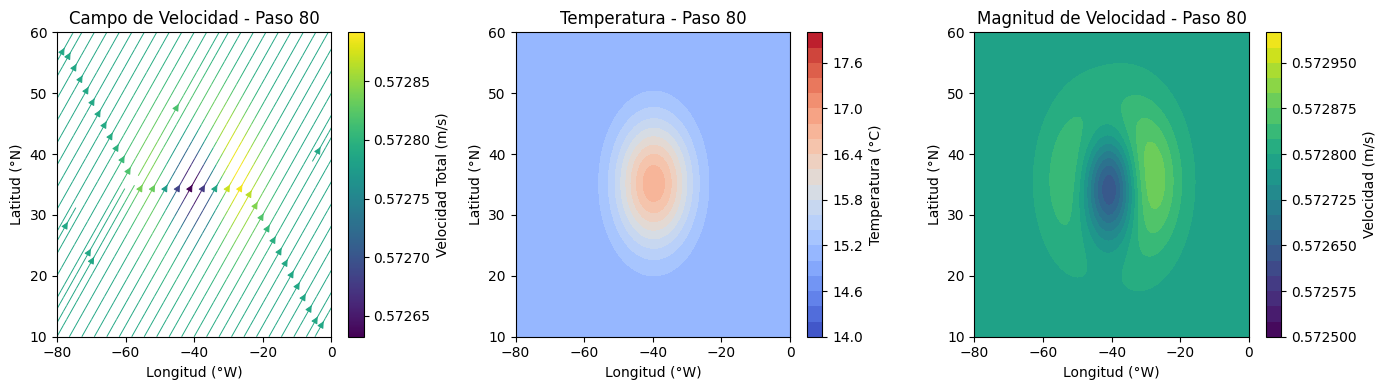

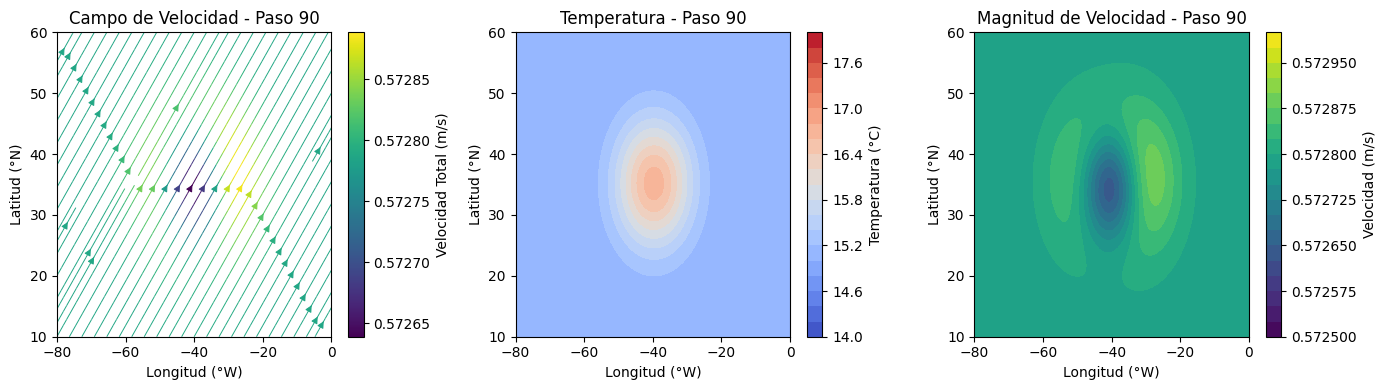

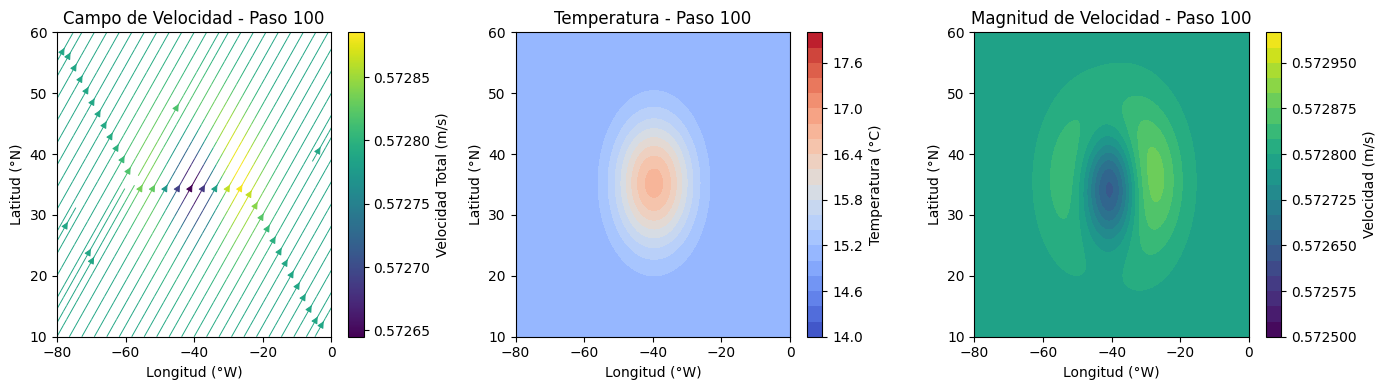

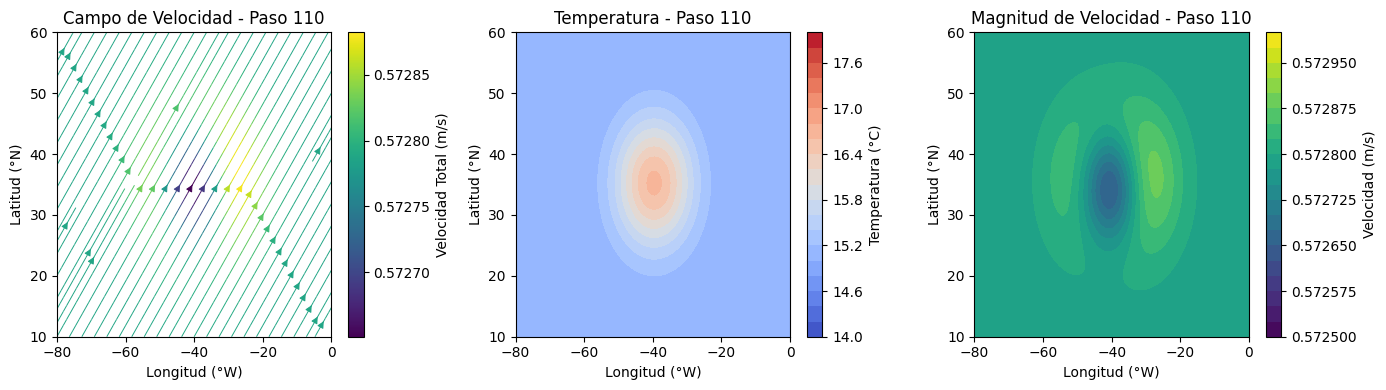

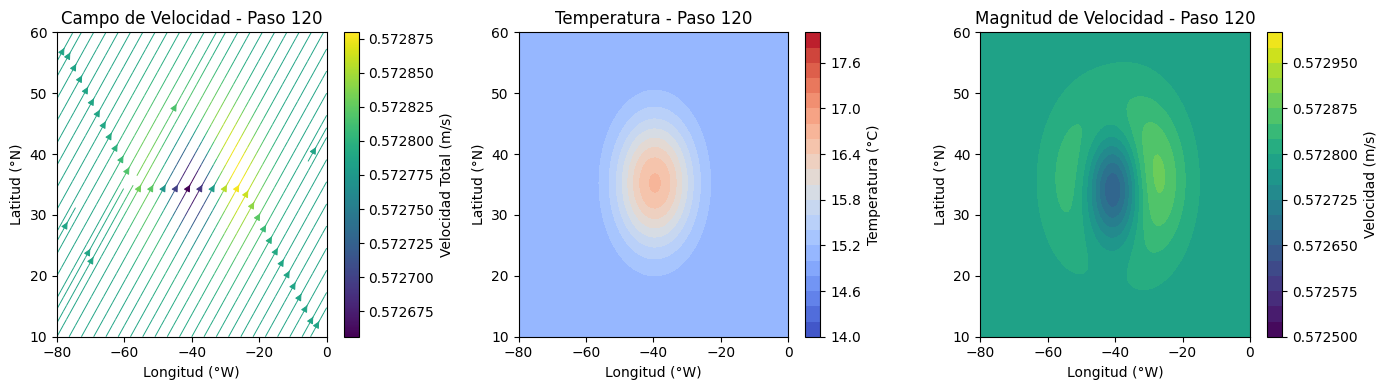

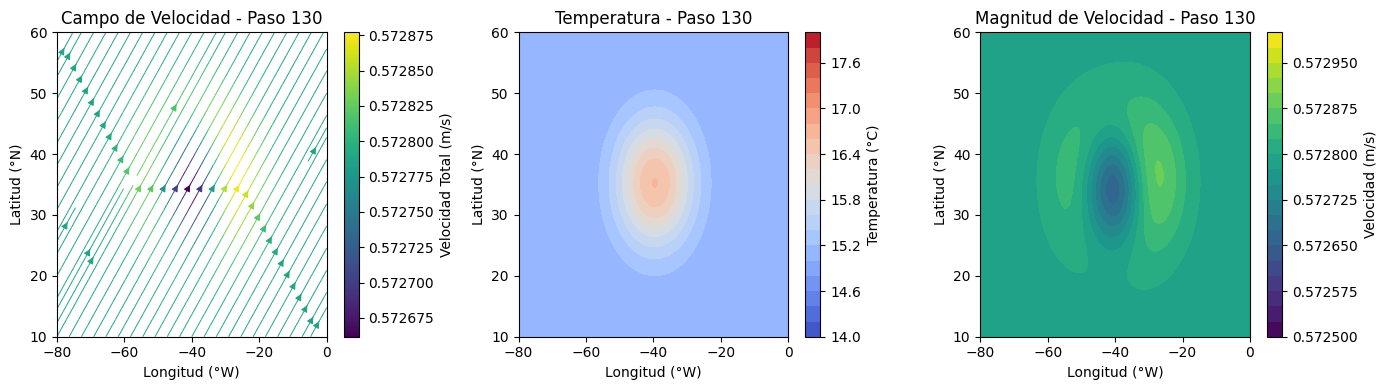

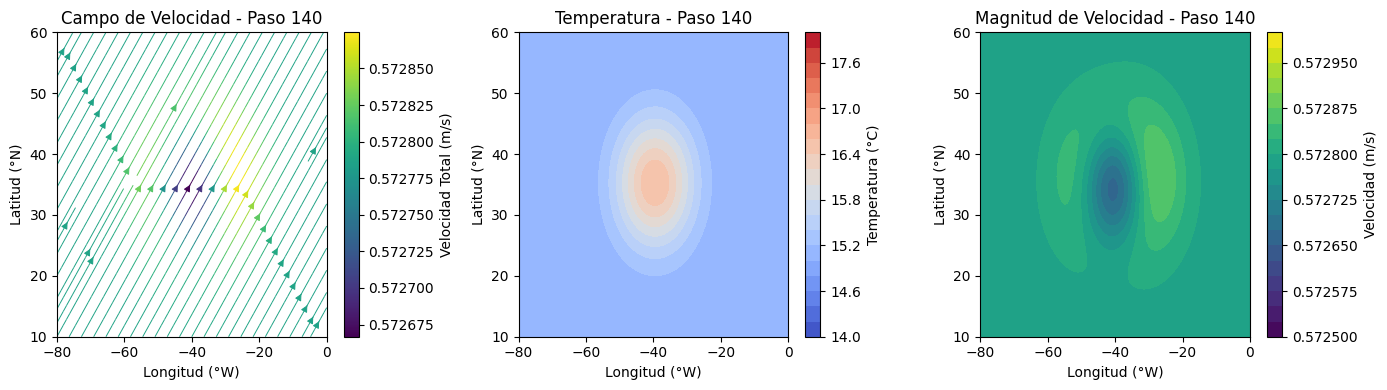

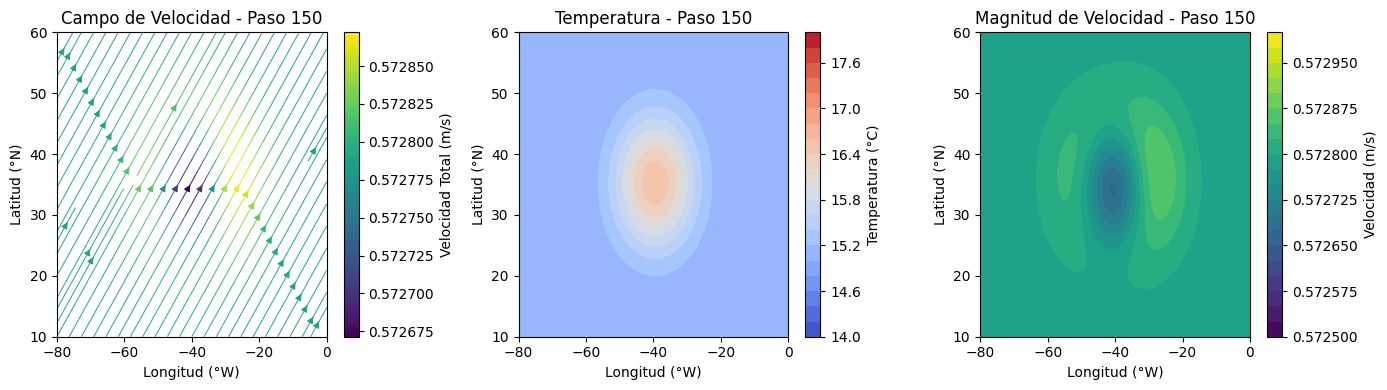

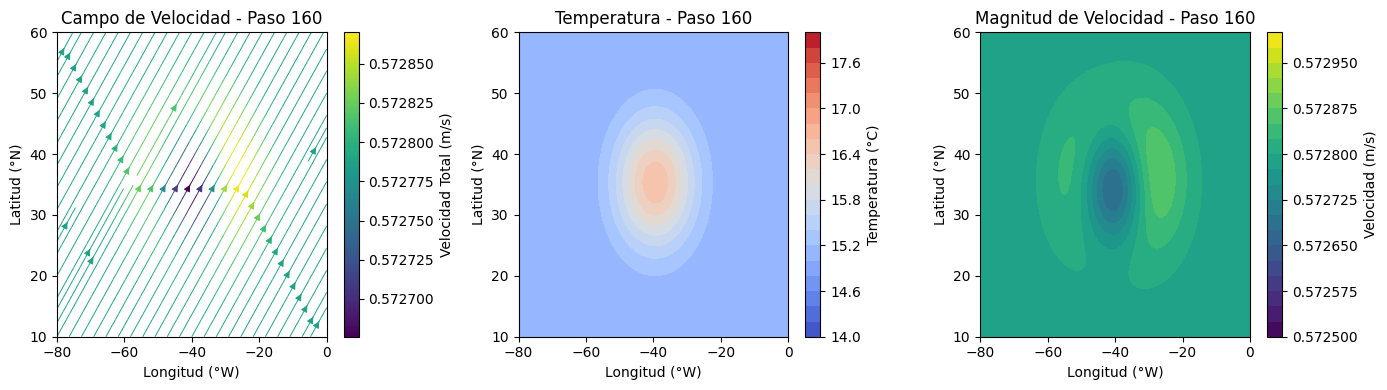

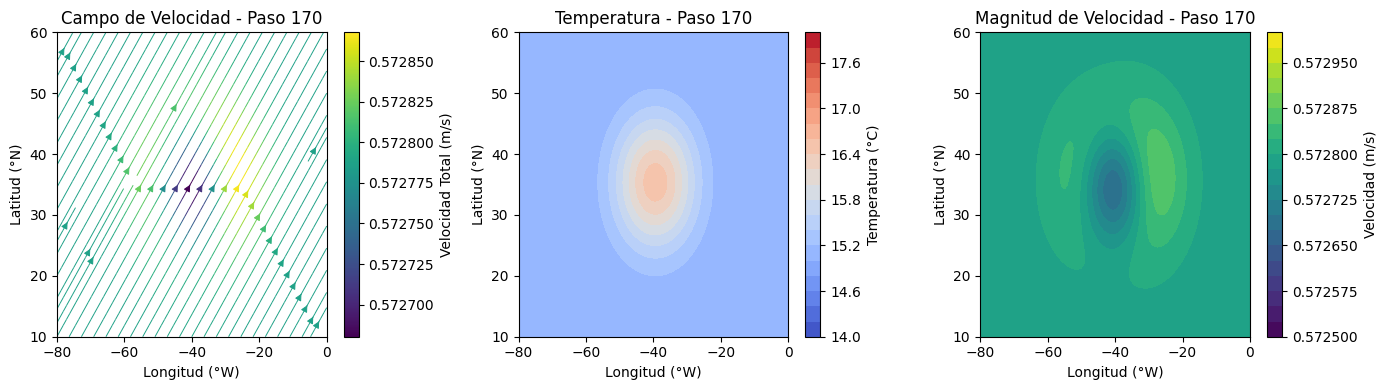

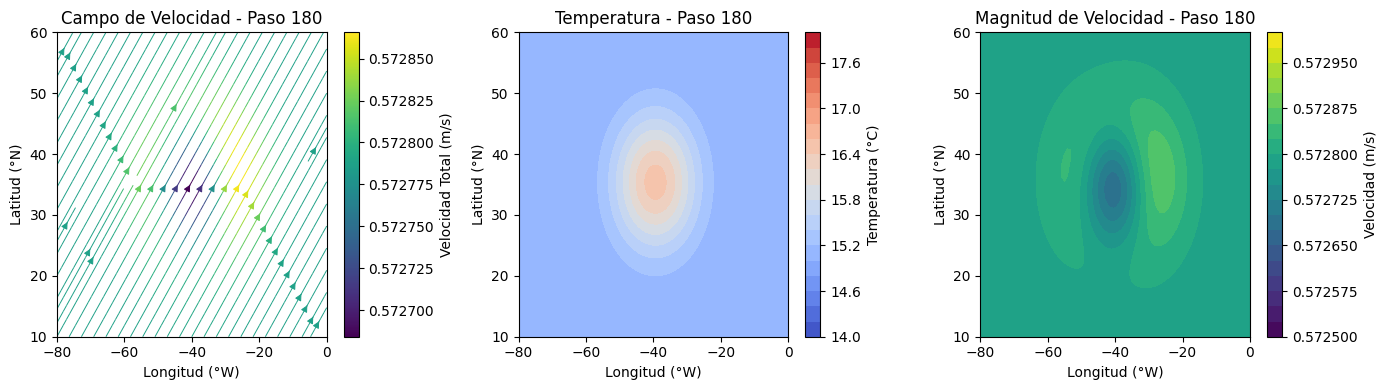

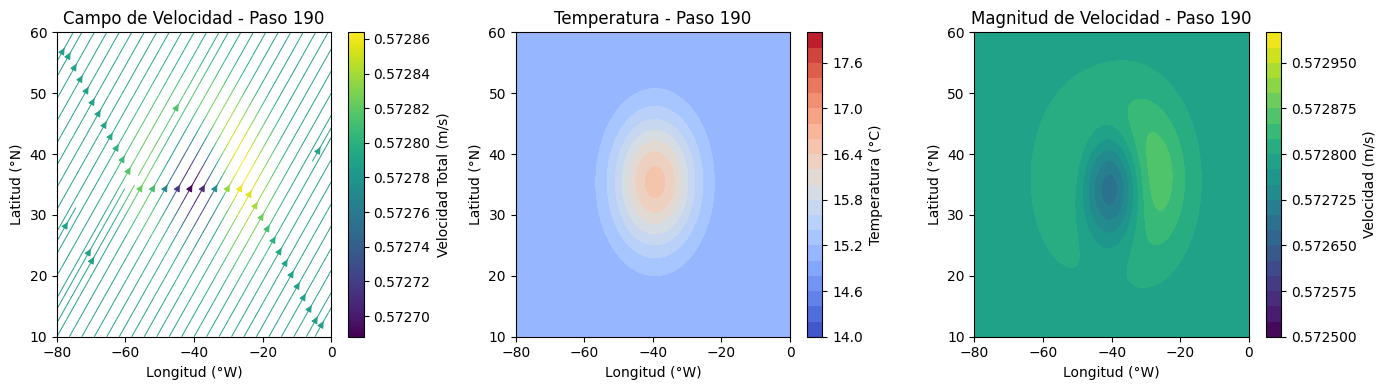

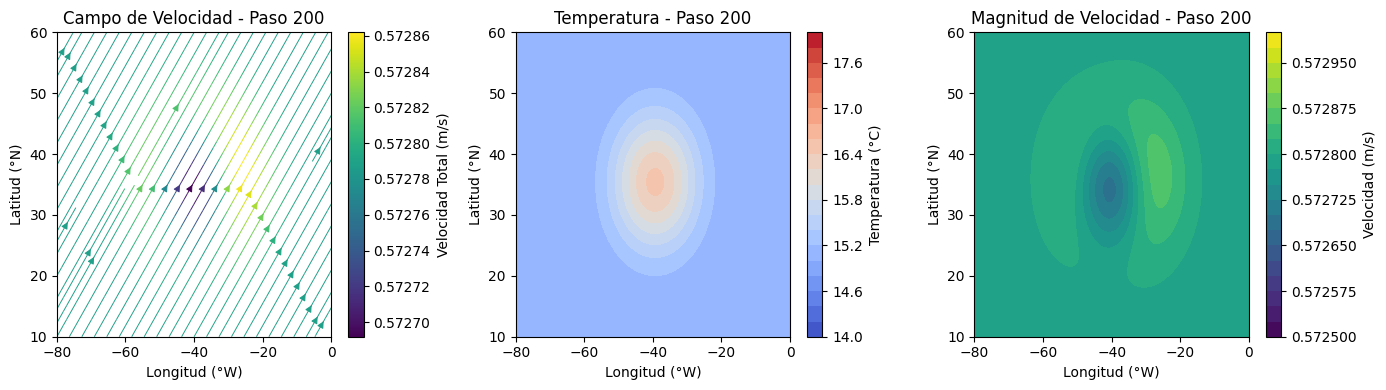

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros
dx = 1  # Paso espacial
dy = 1
dt = 0.1  # Paso temporal
steps = 210  # Número de pasos de simulación

rho0 = 1025  # Densidad base (kg/m^3)
T0 = 15  # Temperatura base (°C)
P0 = 100  # Presión base (Pa)
a = 0.03  # Coeficiente de densidad respecto a T
b = 1  # Coeficiente de presión respecto a rho
c=0.01 #derivada de v respecto rho
d=0.01 #derivada de v respecto P
beta = 0.001  # Parámetro de evolución de densidad
gamma = 0.0001  # Parámetro de evolución de presión
D = 1  # Coeficiente de difusión térmica
alpha = 0.1  # Parámetro de evolución de velocidad
model = "linear"  # Modelo de gradiente
lat_scale = 35  # Escala para la dependencia en latitud
lon_scale = 40  # Escala para la dependencia en longitud
Omega = 7.2921e-5  # Velocidad angular de la Tierra (rad/s)
profundidad=1000
nx, ny = 100, 100 # Dimensiones de la malla
latitudes = np.linspace(10, 60, nx)
longitudes = np.linspace(-80, 0, ny)
X, Y = np.meshgrid(longitudes, latitudes)

temperature = T0 * np.ones((nx, ny))
density = rho0 * np.ones((nx, ny))
pressure = P0 * np.ones((nx, ny))

velocity_x = np.ones((nx, ny))
velocity_y = np.ones((nx, ny))

lat0 = (latitudes[0] + latitudes[-1]) / 3
lon0 = (longitudes[0] + longitudes[-1]) / 3

Longitudes, Latitudes = np.meshgrid(longitudes, latitudes)

# Perturbación 
x0, y0 = -40, 35 
sigma = 7
T_perturbation = 2 * np.exp(-((Longitudes - x0)**2 + (Latitudes - y0)**2) / (2 * sigma**2))
temperature += T_perturbation

# Frecuencia de Coriolis 
f = 2 * Omega * np.sin(np.deg2rad(Y))

# Viento 
U = -10 * np.ones(Y.shape)  
V = np.zeros(Y.shape)  

# Esfuerzo del viento
Cd = 1.2e-3  
tau_x = Cd * U**2 * np.sign(U)
tau_y = Cd * V**2 * np.sign(V)


Longitudes, Latitudes = np.meshgrid(longitudes, latitudes)

def calculate_pressure_gradient(Longitudes, Latitudes,new_density, P0, model, lat_scale=40, lon_scale=20):
    if model == "exponential":
        grad_P_y = -P0 * np.exp(-(Latitudes - lat_scale) / lat_scale)
        grad_P_x = P0 * np.exp(-(Longitudes + lon_scale) / lon_scale)
    elif model == "linear":
        delta_t = (new_density - rho0)
        P_prime = delta_t
        grad_P_y = - P_prime*P0 * (Latitudes - lat_scale) / lat_scale
        grad_P_x = (Longitudes + lon_scale) / lon_scale * P0 *P_prime
    elif model == "sinusoidal":
        grad_P_y = -P0 * np.sin(np.deg2rad(Latitudes / lat_scale))
        grad_P_x = P0 * np.cos(np.deg2rad(Longitudes / lon_scale))
    else:
        raise ValueError(f"Modelo '{model}' no reconocido.")
    return grad_P_x, grad_P_y


def laplacian(field, dx, dy):
    return (np.roll(field, 1, axis=0) + np.roll(field, -1, axis=0) +
            np.roll(field, 1, axis=1) + np.roll(field, -1, axis=1) -
            4 * field) / (dx**2)

def advection(field, velocity_x, velocity_y, dx, dy, dt):
    """ Calcula la advección de un campo escalar dado un campo de velocidad """
    dTdx = (field - np.roll(field, 1, axis=1)) / dx
    dTdy = (field - np.roll(field, 1, axis=0)) / dy
    return -velocity_x * dTdx * dt - velocity_y * dTdy * dt

def update_system(temperature, density, pressure, velocity_x, velocity_y):
    lap_T = laplacian(temperature, dx, dy)
    adv_T = advection(temperature, velocity_x, velocity_y, dx, dy, dt)

    new_temperature = temperature + (D * lap_T + adv_T) * dt
    new_density = rho0 + a * (new_temperature - T0)
    new_pressure = P0 + b * (new_density - rho0)
    
    new_density += dt * (-velocity_x * (new_density - np.roll(new_density, 1, axis=0)) / dx -
                          velocity_y * (new_density - np.roll(new_density, 1, axis=1)) / dy + beta * new_density)
    
    new_pressure += dt * (-velocity_x * (new_pressure - np.roll(new_pressure, 1, axis=0)) / dx -
                           velocity_y * (new_pressure - np.roll(new_pressure, 1, axis=1)) / dy + gamma * new_pressure)
    
    func_rho = a * (new_temperature - T0)
    func_P = b * (new_density - rho0)
    dvdrho = c
    dvdp = d
    
    # Transporte de Ekman
    Q_x_ekman = tau_y / (f * (rho0 + func_rho)) 
    Q_y_ekman = -tau_x / (f * (rho0 + func_rho))  
    
    # Gradiente de presión dinámico
    grad_P_x, grad_P_y = calculate_pressure_gradient(X, Y, new_density, P0, model=model, lat_scale=lat_scale, lon_scale=lon_scale)

    
    # Transporte debido al gradiente de presión
    Q_x_pressure = grad_P_y / ((rho0 + func_rho) * f)
    Q_y_pressure = grad_P_x / ((rho0 + func_rho) * f)
    
    # Transporte total (Ekman + Gradiente de presión)
    velocity_x = (Q_x_ekman + Q_x_pressure)/profundidad
    velocity_y = (Q_y_ekman + Q_y_pressure)/profundidad

    new_velocity_x = ( (beta * (new_density) + (new_temperature - temperature) / dt * a) * ((b*dvdp)+dvdrho)+((gamma*(new_pressure))+dvdp))/alpha #+ velocity_x
    new_velocity_y = ((beta * (new_density) + (new_temperature - temperature) / dt * a) * ((b*dvdp)+dvdrho)+((gamma*(new_pressure))+dvdp))/alpha  #+ velocity_y                     
    
    return new_temperature, new_density, new_pressure, new_velocity_x, new_velocity_y
for step in range(steps):

    temperature, density, pressure, velocity_x, velocity_y = update_system(temperature, density, pressure, velocity_x, velocity_y)
    
    if step % 10 == 0:
        plt.figure(figsize=(14, 4))
        plt.subplot(1, 3, 1)
        speed = np.sqrt(velocity_x**2 + velocity_y**2)
        plt.streamplot(X, Y, velocity_x, velocity_y, color=speed, cmap="viridis", density=1.5, linewidth=0.7, arrowsize=1)
        plt.colorbar(label="Velocidad Total (m/s)")
        plt.title(f"Campo de Velocidad - Paso {step}")
        plt.xlabel("Longitud (°W)")
        plt.ylabel("Latitud (°N)")

        plt.subplot(1, 3, 2)
        plt.contourf(X, Y, temperature,levels=np.linspace(14, 18, 21),cmap='coolwarm')
        plt.colorbar(label='Temperatura (°C)')
        plt.title(f'Temperatura - Paso {step}')
        plt.xlabel("Longitud (°W)")
        plt.ylabel("Latitud (°N)")
        
        
        plt.subplot(1, 3, 3)
        speed = np.sqrt(velocity_x**2 + velocity_y**2)
        plt.contourf(X, Y, speed,levels=np.linspace(0.5725, 0.573, 21), cmap="viridis")
        plt.colorbar(label="Velocidad (m/s)")
        plt.title(f"Magnitud de Velocidad - Paso {step}")
        plt.xlabel("Longitud (°W)")
        plt.ylabel("Latitud (°N)")
        plt.tight_layout()
        plt.show()


        if step == 10:
        
            centro_lon = -40
            centro_lat = 35
            deg2m = 111000  
            r_i = np.sqrt((X - centro_lon)**2 + (Y - centro_lat)**2) * deg2m
            l_i=np.sqrt((0.5**2 + 0.8**2)) * deg2m
            velocidad_magnitud = np.sqrt(velocity_x**2 + velocity_y**2)
            P_i = velocidad_magnitud * l_i

            np.save("C:\\Users\\Ana\\Desktop\\Python TFG\\paso_101.npy", P_i)

        if step == 200:
            centro_lon = -40
            centro_lat = 35
            deg2m = 111000 
    
            r_i = np.sqrt((X - centro_lon)**2 + (Y - centro_lat)**2) * deg2m
            l_i=np.sqrt((0.5**2 + 0.8**2)) * deg2m
            velocidad_magnitud = np.sqrt(velocity_x**2 + velocity_y**2)
            P_i = velocidad_magnitud * l_i

            np.save("C:\\Users\\Ana\\Desktop\\Python TFG\\paso_2001.npy", P_i)
